In [1]:
# We will start by fixing the seed for reproducibility
seed = 0
import torch
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

In [2]:
try:
    import pgmuvi
except ImportError:
    %pip install git+https://github.com/ICSM/pgmuvi.git
    import pgmuvi

In [3]:
try:
    import astropy
except ImportError:
    %pip install astropy
    import astropy

In [4]:
from astropy.table import Table
from pathlib import Path
p = Path('C:/Users/peter/Downloads/lightcurve_2d.vot')
table = Table.read(p, format='votable')

In [5]:
import gpytorch

c:\Users\peter\anaconda3\envs\pgmuvi_dev\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
x, y, yerr = table['x'].value, table['y'].value, table['yerr'].value

In [7]:
# print(x.min(dim=0), x.max(dim=0), y.min(), y.max())

In [8]:
print(x.shape, y.shape, yerr.shape)

(1, 2, 1354) (1, 1354) (1, 1354)


In [9]:
print(x[0, 1])

[564.364501953125 3.5453460216522217 567.3599853515625 ...
 4.886754989624023 1162.0 4.886754989624023]


In [10]:
# looks like we need to unroll x - each pair of values is a time and a wavelength but they are not separated into different columns
x = x.reshape(-1, 2)
print(x.shape)
print(x)

(1354, 2)
[[0.0 0.4783500134944916]
 [2.99242901802063 0.4783500134944916]
 [6.071380138397217 0.4783500134944916]
 [23.005996704101562 0.4783500134944916]
 [27.02593994140625 0.4783500134944916]
 [29.982131958007812 0.4783500134944916]
 [30.03873634338379 0.4783500134944916]
 [33.01871871948242 0.4783500134944916]
 [43.001182556152344 0.4783500134944916]
 [126.31314849853516 0.4783500134944916]
 [132.3157196044922 0.4783500134944916]
 [141.271240234375 0.4783500134944916]
 [144.3118438720703 0.4783500134944916]
 [147.29676818847656 0.4783500134944916]
 [156.2979736328125 0.4783500134944916]
 [159.33763122558594 0.4783500134944916]
 [162.29273986816406 0.4783500134944916]
 [165.3170928955078 0.4783500134944916]
 [168.2939910888672 0.4783500134944916]
 [171.29266357421875 0.4783500134944916]
 [174.31639099121094 0.4783500134944916]
 [178.29591369628906 0.4783500134944916]
 [180.21141052246094 0.4783500134944916]
 [181.31422424316406 0.4783500134944916]
 [184.25823974609375 0.47835001349

[]

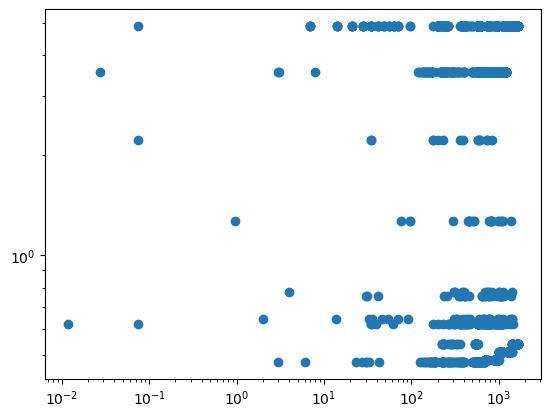

In [11]:
import matplotlib.pyplot as plt
plt.plot(x[:,0], x[:,1], 'o')
plt.loglog()

In [12]:
# now we can turn these into inputs for the model
t = x[:,0]
w = x[:,1]
x = torch.stack([torch.tensor(t), torch.tensor(w)], 0).T
print(x.shape)
y = torch.tensor(y)
yerr = torch.tensor(yerr)
print(torch.isnan(yerr).sum())
nans = torch.isnan(yerr)
print(nans.sum())
x = x[~nans.flatten()]
y = y[~nans]
yerr = yerr[~nans]
x.shape, y.shape, yerr.shape

torch.Size([1354, 2])
tensor(66)
tensor(66)


(torch.Size([1288, 2]), torch.Size([1288]), torch.Size([1288]))

In [13]:
from pgmuvi.lightcurve import Lightcurve
lightcurve2d = Lightcurve(x, y, yerr=yerr, transform='minmax')

In [14]:
if torch.cuda.is_available():
    print('Using GPU')
    lightcurve2d = lightcurve2d.cuda()

In [15]:
from pgmuvi.gps import SpectralMixtureTimesRBFGPModel

In [16]:
likelihood = gpytorch.likelihoods.FixedNoiseGaussianLikelihood(noise=yerr,
                                                               learn_additional_noise=True)
model = SpectralMixtureTimesRBFGPModel(lightcurve2d._xdata_transformed,
                                       lightcurve2d._ydata_transformed, likelihood,
                                       num_mixtures=1)

kernels.0.kernels.0.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
kernels.0.kernels.0.base_kernel.raw_mixture_weights Parameter containing:
tensor([0.], requires_grad=True)
kernels.0.kernels.0.base_kernel.raw_mixture_means Parameter containing:
tensor([[[0.]]], requires_grad=True)
kernels.0.kernels.0.base_kernel.raw_mixture_scales Parameter containing:
tensor([[[0.]]], requires_grad=True)
kernels.0.kernels.1.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
kernels.0.kernels.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[0.]], requires_grad=True)
kernels.1.raw_outputscale Parameter containing:
tensor(0., requires_grad=True)
kernels.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[0., 0.]], requires_grad=True)


In [17]:
for name, param in model.named_parameters():
    print(f'{name}: {param}, {param.shape}')

likelihood.second_noise_covar.raw_noise: Parameter containing:
tensor([0.], requires_grad=True), torch.Size([1])
mean_module.raw_constant: Parameter containing:
tensor(0., requires_grad=True), torch.Size([])
covar_module.kernels.0.kernels.0.raw_outputscale: Parameter containing:
tensor(0., requires_grad=True), torch.Size([])
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_weights: Parameter containing:
tensor([0.], requires_grad=True), torch.Size([1])
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_means: Parameter containing:
tensor([[[0.]]], requires_grad=True), torch.Size([1, 1, 1])
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_scales: Parameter containing:
tensor([[[0.]]], requires_grad=True), torch.Size([1, 1, 1])
covar_module.kernels.0.kernels.1.raw_outputscale: Parameter containing:
tensor(0., requires_grad=True), torch.Size([])
covar_module.kernels.0.kernels.1.base_kernel.raw_lengthscale: Parameter containing:
tensor([[0.]], requires_grad=True), tor

In [78]:
# Add initial guesses for some hyperparameters
hypers = {
    'mean_module.constant': y.mean(),
    'covar_module.kernels.1.base_kernel.lengthscale': torch.tensor([[0.002, 0.1]]), 
    'covar_module.kernels.0.kernels.1.base_kernel.lengthscale': torch.tensor([[0.1]]),
    'covar_module.kernels.0.kernels.1.outputscale': torch.tensor([[0.0]]),
    'covar_module.kernels.0.kernels.0.base_kernel.mixture_means': torch.tensor([[[10.0]]]),
    'covar_module.kernels.0.kernels.0.base_kernel.mixture_scales': torch.tensor([[[0.01]]]),
    'likelihood.second_noise_covar.noise': torch.tensor([0.1]),
}
for key, value in hypers.items():
    print(key, value.shape)

model.initialize(**hypers)

mean_module.constant torch.Size([])
covar_module.kernels.1.base_kernel.lengthscale torch.Size([1, 2])
covar_module.kernels.0.kernels.1.base_kernel.lengthscale torch.Size([1, 1])
covar_module.kernels.0.kernels.1.outputscale torch.Size([1, 1])
covar_module.kernels.0.kernels.0.base_kernel.mixture_means torch.Size([1, 1, 1])
covar_module.kernels.0.kernels.0.base_kernel.mixture_scales torch.Size([1, 1, 1])
likelihood.second_noise_covar.noise torch.Size([1])


SpectralMixtureTimesRBFGPModel(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
    (second_noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): Interval(3.863E-05, 4.881E+00)
    )
  )
  (mean_module): ConstantMean(
    (raw_constant_constraint): Interval(1.151E+00, 2.181E+01)
  )
  (covar_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ProductKernel(
        (kernels): ModuleList(
          (0): ScaleKernel(
            (base_kernel): SpectralMixtureKernel(
              (raw_mixture_scales_constraint): Positive()
              (raw_mixture_means_constraint): Positive()
              (raw_mixture_weights_constraint): Positive()
            )
            (raw_outputscale_constraint): Positive()
          )
          (1): ScaleKernel(
            (base_kernel): RBFKernel(
              (raw_lengthscale_constraint): Positive()
            )
            (raw_outputscale_constraint): Positive()
          )
        )
      )
 

In [81]:
model.covar_module.kernels[1].raw_outputscale.requires_grad = False
model.covar_module.kernels[1].base_kernel.raw_lengthscale.requires_grad = False

In [82]:
lightcurve2d.set_likelihood(likelihood)
lightcurve2d.set_model(model)

In [83]:
# # Add initial guesses for some hyperparameters
# hypers = {
#     'mean_module.constant': y.mean(),
#     'covar_module.kernels.1.base_kernel.lengthscale': torch.tensor([[0.1, 0.1]]), 
#     'covar_module.kernels.0.kernels.1.base_kernel.lengthscale': torch.tensor([[0.1]]),
#     'covar_module.kernels.0.kernels.0.base_kernel.mixture_means': torch.tensor([[[0.01]]]),
# }
# for key, value in hypers.items():
#     print(key, value.shape)
# lightcurve2d.set_hypers(hypers=hypers)

In [93]:
lightcurve2d.fit(training_iter=300) #, likelihood='learn')

are not yet implemented for 2D data
PLEASE SET CONSTRAINTS MANUALLY
likelihood.second_noise_covar.noise: tensor([0.1242])
mean_module.constant: 12.099237442016602
covar_module.kernels.0.kernels.0.outputscale: 2.9712536334991455
covar_module.kernels.0.kernels.0.base_kernel.mixture_weights: tensor([2.9709])
covar_module.kernels.0.kernels.0.base_kernel.mixture_means: tensor([[[0.0058, 2.2013]]])
covar_module.kernels.0.kernels.0.base_kernel.mixture_scales: tensor([[[6.7941e-06, 2.5970e-03]]])
covar_module.kernels.0.kernels.1.outputscale: 0.0
covar_module.kernels.0.kernels.1.base_kernel.lengthscale: tensor([[0.1065]])
covar_module.kernels.1.outputscale: 10.470165252685547
covar_module.kernels.1.base_kernel.lengthscale: tensor([[0.0020, 0.1000]])


100%|██████████| 300/300 [00:44<00:00,  6.73it/s]


{'loss': [array(2.0779867, dtype=float32),
  array(2.0998044, dtype=float32),
  array(2.075579, dtype=float32),
  array(2.0570824, dtype=float32),
  array(2.0656738, dtype=float32),
  array(2.0945337, dtype=float32),
  array(2.1001925, dtype=float32),
  array(2.118845, dtype=float32),
  array(2.0827115, dtype=float32),
  array(2.0742133, dtype=float32),
  array(2.06692, dtype=float32),
  array(2.0654616, dtype=float32),
  array(2.0764062, dtype=float32),
  array(2.1112967, dtype=float32),
  array(2.0537038, dtype=float32),
  array(2.0613158, dtype=float32),
  array(2.0699894, dtype=float32),
  array(2.0993888, dtype=float32),
  array(2.0982888, dtype=float32),
  array(2.0922832, dtype=float32),
  array(2.1045983, dtype=float32),
  array(2.0755408, dtype=float32),
  array(2.0849483, dtype=float32),
  array(2.0676126, dtype=float32),
  array(2.058956, dtype=float32),
  array(2.0723724, dtype=float32),
  array(2.0598502, dtype=float32),
  array(2.0784822, dtype=float32),
  array(2.0791342

In [94]:
'mean_module.constant' in lightcurve2d._model_pars

True

In [95]:
lightcurve2d._xdata_transformed

tensor([[0.0000, 0.0000],
        [0.0018, 0.0000],
        [0.0036, 0.0000],
        ...,
        [0.6813, 1.0000],
        [0.6854, 1.0000],
        [0.6896, 1.0000]])

In [96]:
lightcurve2d.print_results()

loss: [2.0631588]
delta_loss: [0.00067592]
likelihood.second_noise_covar.noise: [0.12892056]
mean_module.constant: [11.89073]
covar_module.kernels.0.kernels.0.outputscale: [2.2708275]
covar_module.kernels.0.kernels.0.base_kernel.mixture_weights: [2.270598]
covar_module.kernels.0.kernels.0.base_kernel.mixture_means: [0.00426612 1.6307045 ]
covar_module.kernels.0.kernels.0.base_kernel.mixture_scales: [2.1354314e-05 8.1625860e-03]
covar_module.kernels.0.kernels.1.outputscale: [0.]
covar_module.kernels.0.kernels.1.base_kernel.lengthscale: [0.18075451]
covar_module.kernels.1.outputscale: [10.470165]
covar_module.kernels.1.base_kernel.lengthscale: [0.002      0.09999998]


In [97]:
for key, value in model.named_parameters():
    print(key, value)

likelihood.second_noise_covar.raw_noise Parameter containing:
tensor([-3.6075], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0.0790, requires_grad=True)
covar_module.kernels.0.kernels.0.raw_outputscale Parameter containing:
tensor(2.1619, requires_grad=True)
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_weights Parameter containing:
tensor([2.1616], requires_grad=True)
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_means Parameter containing:
tensor([[[7.1880]]], requires_grad=True)
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_scales Parameter containing:
tensor([[[-3.3066]]], requires_grad=True)
covar_module.kernels.0.kernels.1.raw_outputscale Parameter containing:
tensor(-inf, requires_grad=True)
covar_module.kernels.0.kernels.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.6189]], requires_grad=True)
covar_module.kernels.1.raw_outputscale Parameter containing:
tensor(10.4701)
covar_module.kernels.1.base_ke

In [98]:
for key, value in lightcurve2d.model.named_parameters():
    print(key, value)

likelihood.second_noise_covar.raw_noise Parameter containing:
tensor([-3.6075], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0.0790, requires_grad=True)
covar_module.kernels.0.kernels.0.raw_outputscale Parameter containing:
tensor(2.1619, requires_grad=True)
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_weights Parameter containing:
tensor([2.1616], requires_grad=True)
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_means Parameter containing:
tensor([[[7.1880]]], requires_grad=True)
covar_module.kernels.0.kernels.0.base_kernel.raw_mixture_scales Parameter containing:
tensor([[[-3.3066]]], requires_grad=True)
covar_module.kernels.0.kernels.1.raw_outputscale Parameter containing:
tensor(-inf, requires_grad=True)
covar_module.kernels.0.kernels.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.6189]], requires_grad=True)
covar_module.kernels.1.raw_outputscale Parameter containing:
tensor(10.4701)
covar_module.kernels.1.base_ke

In [99]:
# lightcurve2d.print_periods()

In [100]:
# lightcurve2d.plot_psd()

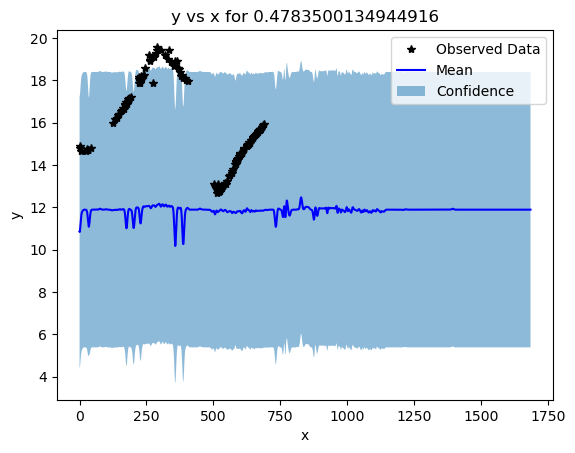

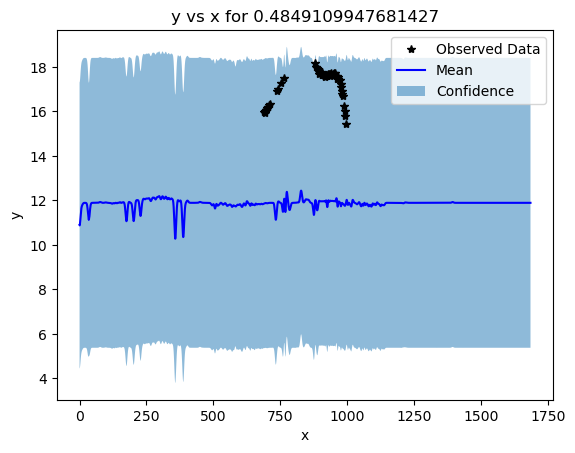

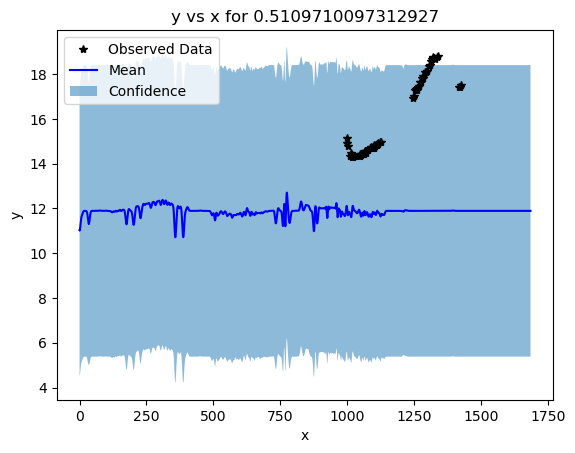

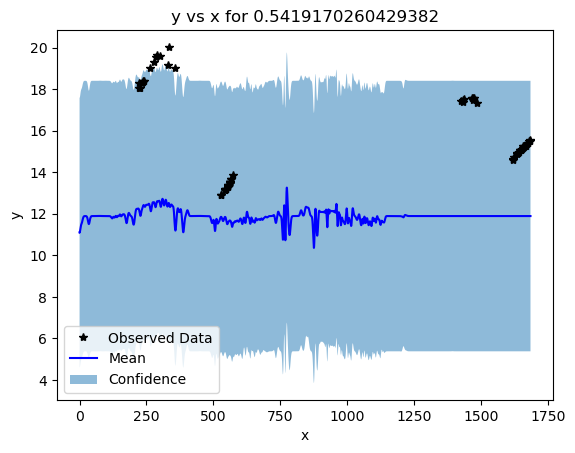

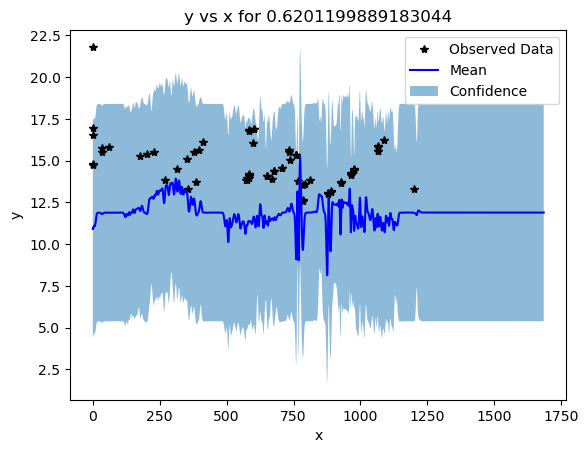

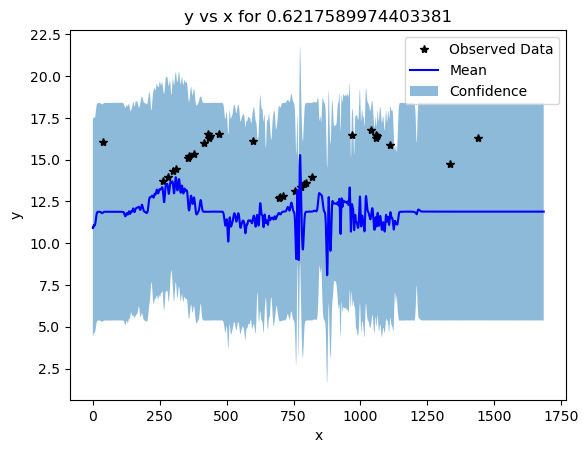

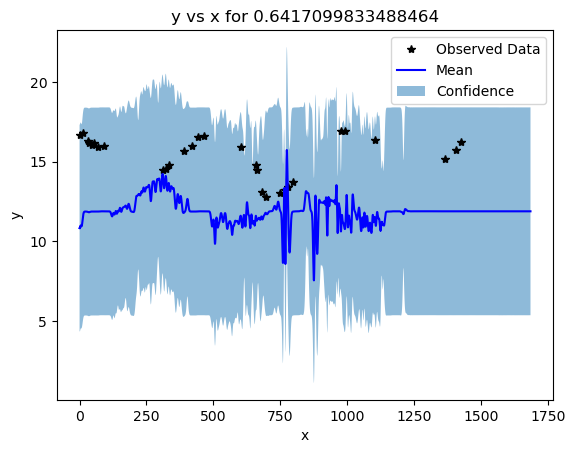

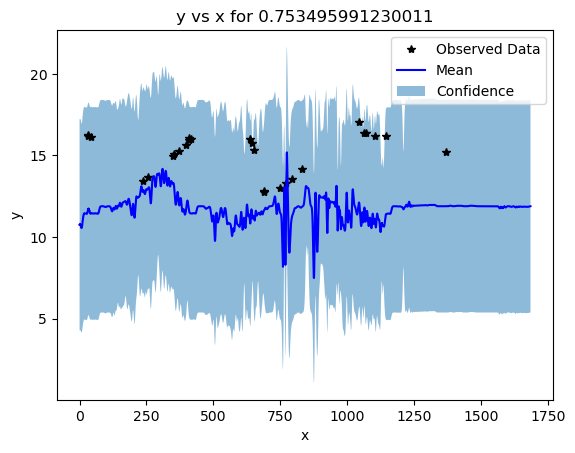

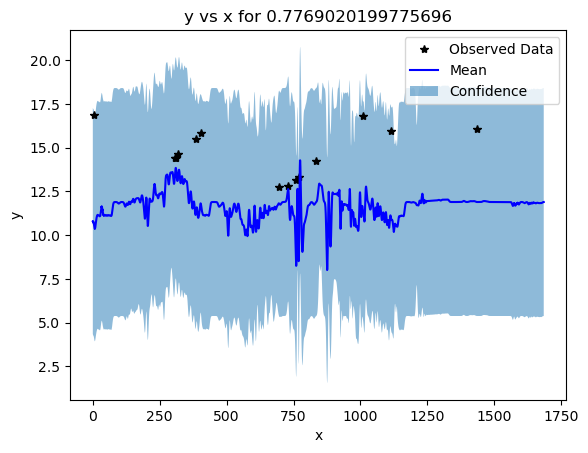

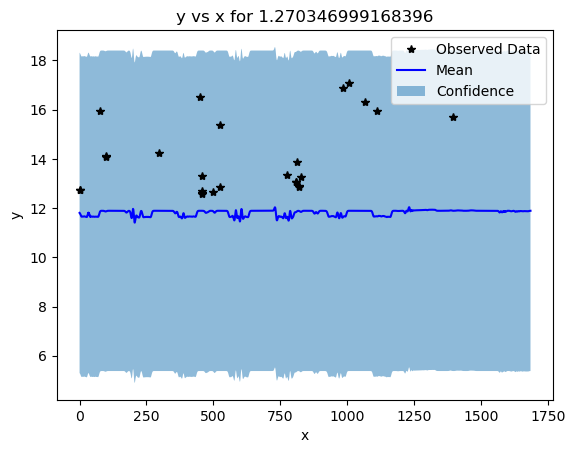

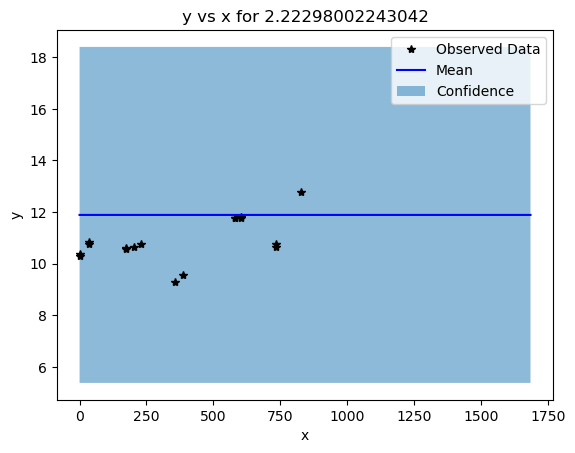

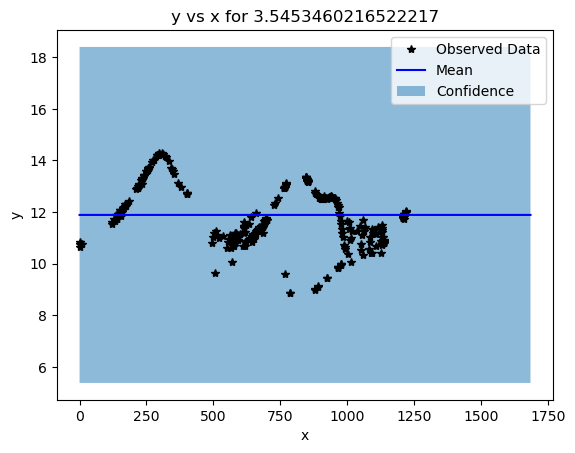

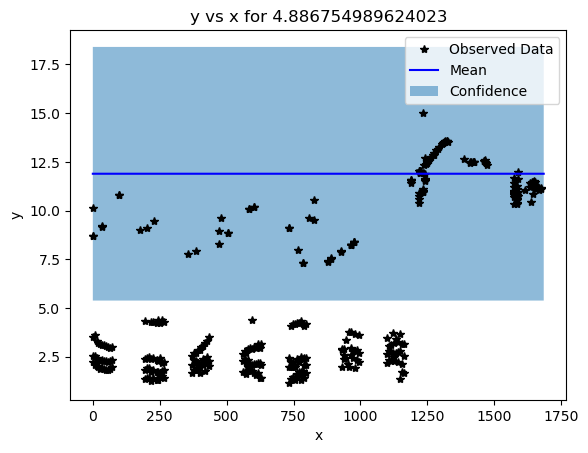

[<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>]

In [101]:
lightcurve2d.plot(ylim=False)